<h1>Optimization - MALIS project Key Estimation</h1>

Execute this cell to import everything needed

In [1]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from loading_dataset import prepare_panda_dataFrame
import pandas as pd

LOADING DATASETS

GIANTSTEPS SMALL

In [2]:
# Run this to create a csv file of a dataset
dataset_path="./Datasets/giantsteps-key-dataset-master/audio"
key_annotation_path="./Datasets/giantsteps-key-dataset-master/annotations/key"
chroma_df=prepare_panda_dataFrame(dataset_path,key_annotation_path)

loading ./Datasets/giantsteps-key-dataset-master/audio
What transformation would you like to perform on your dataset,
enter 1 for chromagram, 2 for spectrogram:2
2
Processing data, please wait


/home/mirado/GIT/AI-Key-Detection-Project/loading_dataset.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  audio_key_tuples = np.array(audio_key_tuples)


Audios have correctly been processed 

Do you want to register data into dataframe ? [yes: enter 1/no: enter 0]:0



GIANTSTEPS GIANT

In [35]:
dataset_path = "/home/mirado/GIT/AI-Key-Detection-Project/Datasets/giantsteps-mtg-key-dataset-master/audio/wav/"
key_annotation_path = "/home/mirado/GIT/AI-Key-Detection-Project/Datasets/giantsteps-mtg-key-dataset-master/annotations/mtg_annotations_key/"
chroma_df=prepare_panda_dataFrame(dataset_path,key_annotation_path)

loading /home/mirado/GIT/AI-Key-Detection-Project/Datasets/giantsteps-mtg-key-dataset-master/audio/wav/
What transformation would you like to perform on your dataset,
enter 1 for chromagram, 2 for spectrogram:2
2
Processing data, please wait


/home/mirado/GIT/AI-Key-Detection-Project/loading_dataset.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  audio_key_tuples = np.array(audio_key_tuples)


Audios have correctly been processed 

Do you want to register data into dataframe ? [yes: enter 1/no: enter 0]:0


-------------------- KFold & Stratified KFold --------------------

In [36]:
    # Neural network parameters
    epochs = 400
    iter_for_convergence = epochs
    hidden_layer_sizes = (100,50,30) # these represents the number of neurons IN THE HIDDEN LAYERS ONLYS
    activation = 'logistic'
    validation= True;
    verbose=False;
    learning_rate = 0.008
    
    # Regularization constant
    alpha=0.0

    # NNet init
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, 
                        random_state=1, max_iter=epochs, learning_rate_init=learning_rate, 
                        learning_rate='adaptive', alpha=alpha, early_stopping=validation, 
                        verbose=verbose, n_iter_no_change=iter_for_convergence)

In [37]:
# Preparation of training data
#spectro_gs_df = pd.read_csv("giantsteps_spectro.csv")

X, y = np.stack(chroma_df['chromagram']), np.array(chroma_df['coded_key'].astype('int'))

In [38]:
#kfold = KFold(n_splits=5)
skfold = StratifiedKFold(5)

#y_array_kfold = cross_val_score(mlp, X, y, cv=kfold)
y_array_skfold = cross_val_score(mlp, X, y, cv=skfold)

/home/mirado/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mirado/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mirado/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mirado/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mirado/anaconda3/lib/python3.8/sit

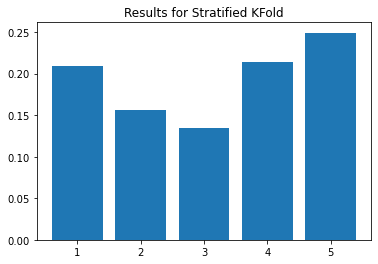

In [55]:
# Ploting the results
x = [i for i in range(1,6)]

for i in range(2):
    #plt.subplot(1,2,i+1)
    #if i==0:
        #plt.bar(x, y_array_kfold)
        #plt.title("Results for KFold")
    if i==1: 
        plt.bar(x, y_array_skfold)
        plt.title("Results for Stratified KFold")

In [42]:
#print("Average accuracy on validation for 5-Fold:", round(y_array_kfold.mean()*100, 2),"%")
print("Average accuracy on validation for Stratified 5-Fold:", round(y_array_skfold.mean()*100,2), "%")

Average accuracy on validation for Stratified 5-Fold: 19.25 %


We recover the best split from the Stratified KFold as it has a better result in terms of accuracy.

In [43]:
accuracy = []
skfold.get_n_splits(X,y)

index = 1
counter = 0

for train_indexes, test_indexes in skfold.split(X,y):
    if (counter == index):
        X_train, X_test = X[train_indexes], X[test_indexes]
        y_train, y_test = y[train_indexes], y[test_indexes]
        break
    counter +=1

-------------------- GRID SEARCH --------------------

In [44]:
# Creating the MLP Classifier and initiating all values for that
epochs = 400
iter_for_convergence = epochs
hidden_layer_sizes = (100,50,30) # these represents the number of neurons IN THE HIDDEN LAYERS ONLYS
activation = 'logistic'
validation= True;
verbose=False;

#mlp = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, activation=activation,
#                   random_state=1, early_stopping=validation,
#                   verbose=verbose, n_iter_no_change=iter_for_convergence)

parameters_dict = {
    'alpha': [0.0001, 0.05],
    'learning_rate_init': [5*10**-3, 10**-3, 8*10**-2]
}

#mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, 
#                        random_state=1, max_iter=epochs, 
#                        learning_rate='adaptive', early_stopping=validation, 
#                        verbose=verbose, n_iter_no_change=iter_for_convergence)

In [45]:
# Performing Gridsearch on the parameters

# n_jobs = number of cores to use (-1 = all available)
# cv = number of splits for cross validation

clf = GridSearchCV(mlp, parameters_dict, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)
#mlp.fit(X_train, y_train)

/home/mirado/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', alpha=0.0,
                                     early_stopping=True,
                                     hidden_layer_sizes=(100, 50, 30),
                                     learning_rate='adaptive',
                                     learning_rate_init=0.008, max_iter=400,
                                     n_iter_no_change=400, random_state=1),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.05],
                         'learning_rate_init': [0.005, 0.001, 0.08]})

In [47]:
df_results = pd.DataFrame(clf.cv_results_)
df_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_learning_rate_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,375.023848,1.445378,0.060724,0.002883,0.0001,0.005,"{'alpha': 0.0001, 'learning_rate_init': 0.005}",0.203540,0.204444,0.213333,0.200000,0.186667,0.201597,0.008661,2
1,369.751936,4.582270,0.062659,0.004938,0.0001,0.001,"{'alpha': 0.0001, 'learning_rate_init': 0.001}",0.203540,0.235556,0.213333,0.213333,0.217778,0.216708,0.010512,1
2,373.064554,3.506866,0.060873,0.005763,0.0001,0.08,"{'alpha': 0.0001, 'learning_rate_init': 0.08}",0.092920,0.106667,0.093333,0.093333,0.093333,0.095917,0.005377,5
3,368.100131,1.661153,0.063610,0.007741,0.05,0.005,"{'alpha': 0.05, 'learning_rate_init': 0.005}",0.097345,0.155556,0.115556,0.146667,0.142222,0.131469,0.021654,4
4,334.674228,62.885834,0.047161,0.012110,0.05,0.001,"{'alpha': 0.05, 'learning_rate_init': 0.001}",0.163717,0.142222,0.164444,0.204444,0.173333,0.169632,0.020193,3
5,201.520794,1.337179,0.021735,0.007392,0.05,0.08,"{'alpha': 0.05, 'learning_rate_init': 0.08}",0.070796,0.093333,0.093333,0.093333,0.062222,0.082604,0.013418,6


In [48]:
df_results[['param_alpha', 'param_learning_rate_init','mean_test_score']]

,param_alpha,param_learning_rate_init,mean_test_score
0,0.0001,0.005,0.201597
1,0.0001,0.001,0.216708
2,0.0001,0.08,0.095917
3,0.05,0.005,0.131469
4,0.05,0.001,0.169632
5,0.05,0.08,0.082604


In [49]:
clf.best_params_

{'alpha': 0.0001, 'learning_rate_init': 0.001}

----------- Studying the F Score -----------

In [50]:
# Initiating the MLP with best parameters
epochs = 500
iter_for_convergence = epochs
hidden_layer_sizes = (100,50,30) # these represents the number of neurons IN THE HIDDEN LAYERS ONLYS
activation = 'logistic'
validation= True;
verbose=False;
learning_rate = 0.001
alpha = 0.0001

    # NNet init
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, 
                        random_state=1, max_iter=epochs, learning_rate_init=learning_rate, 
                        learning_rate='adaptive', alpha=alpha, early_stopping=validation, 
                        verbose=verbose, n_iter_no_change=iter_for_convergence)

In [51]:
mlp.fit(X_train, y_train)

/home/mirado/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', early_stopping=True,
              hidden_layer_sizes=(100, 50, 30), learning_rate='adaptive',
              max_iter=500, n_iter_no_change=500, random_state=1)

In [52]:
from sklearn.metrics import f1_score
y_estimate = mlp.predict(X_test)

# First F score not taking label representation unbalance into account
f1_score(y_test, y_estimate, average='macro')

0.08130478050082855

In [53]:
# First F score taking label representation unbalance into account
f1_score(y_test, y_estimate, average='weighted')

0.1406620786870896

------------ CONFUSION MATRIX ------------

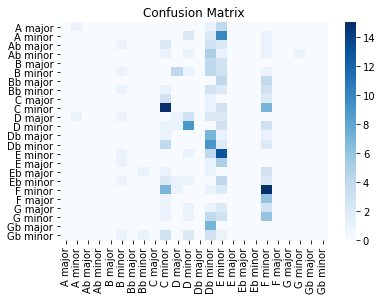

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

keys = 'A major,A minor,Ab major,Ab minor,B major,B minor,Bb major,Bb minor,C major,C minor,D major,D minor,Db major,Db minor,E minor,E major,Eb major,Eb minor,F minor,F major,G major,G minor,Gb major,Gb minor'.split(",")

cf_matrix = confusion_matrix(y_test, y_estimate)
plt.figure()
sns.heatmap(cf_matrix, cmap='Blues', xticklabels=keys, yticklabels=keys)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")